# COMP90072 Project - Code Component

## Imports and Initialisations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

import sow

np.random.seed(90072)
fig: Figure
ax: Axes | list[Axes]


## Basic BTW Model

In this section, we explore the basic BTW model to verify the correctness of 
implementation. 

### Toppling Check

The main aim is to check if toppling proceeded as expected.

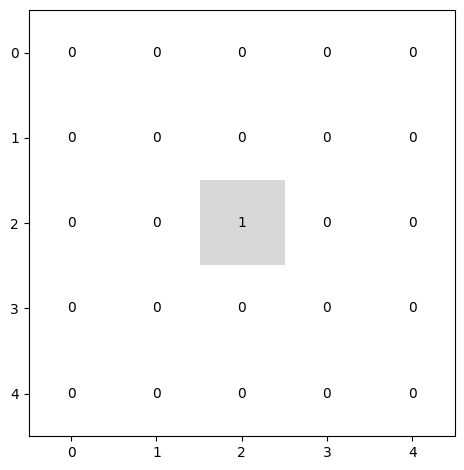

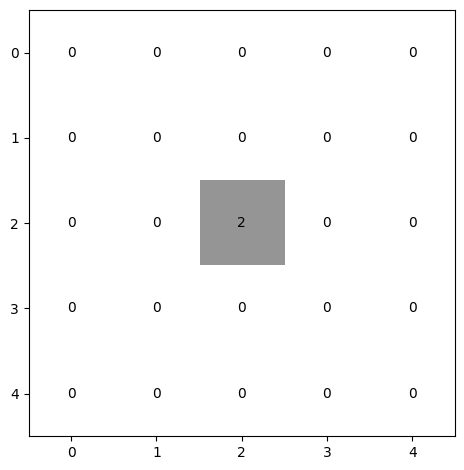

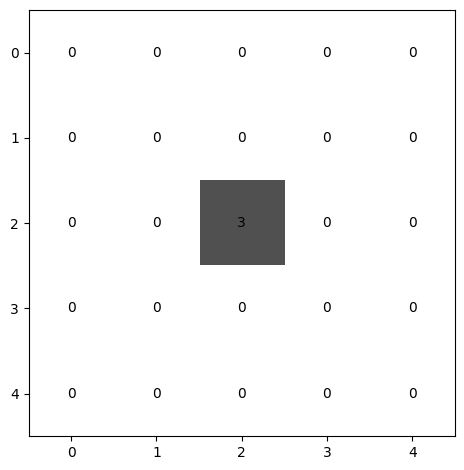

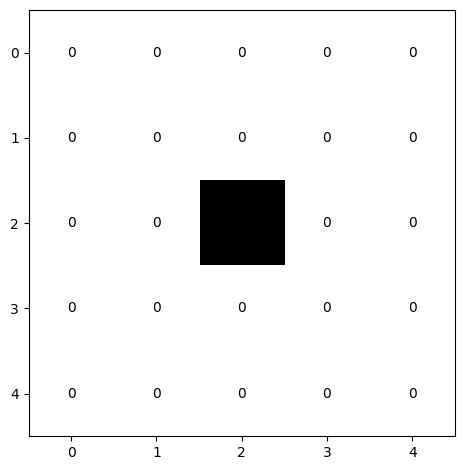

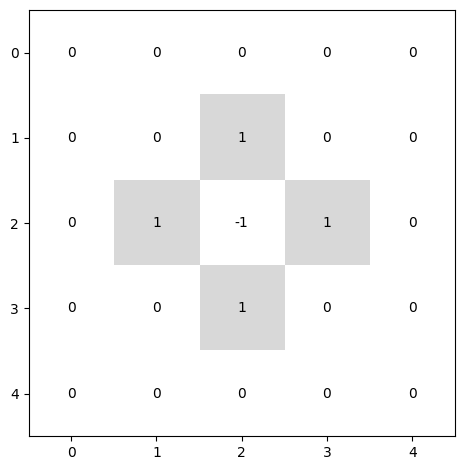

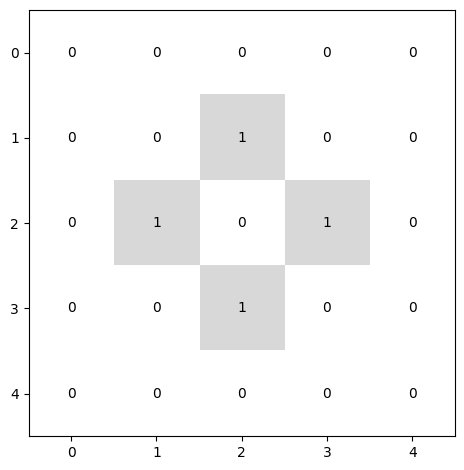

In [3]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(5, 5)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

def grid_visualiser(context: sow.SimulationContext):
    """ Creates a custom grid visualiser.
    
    :param context: The simulation context.
    :return: Figure and axes object generated by matplotlib.
    """
    return sow.visualise_grid(
        5, 5, context.model.height, max_height=context.model.topple_limit, 
        xticks="auto", yticks="auto", labels="auto")

# Create the listeners. 
image_maker = sow.ImageMaker(visualiser=grid_visualiser)
video_maker = sow.MovieMaker(max_frame=model.t_lim)

model.add_listener([
    image_maker
])

# Run the simulation.
_ = model.simulate(6)

# View the images.
for x in image_maker.images[:5]:
    x[0].show()


### Correctness-check: Pattern at Scale

In this subsection, we check if the pattern of the model matches the expected 
pattern of BTW models, as well as its algorithmic complexity.


In [36]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(29, 29)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# We drop at sand at the same spot to check the model. Notice that the middle 
# point is floor of half the vertex count, by design.
model.manager = sow.ConstantDropper(graph.vcount() // 2)

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(100_000_000)

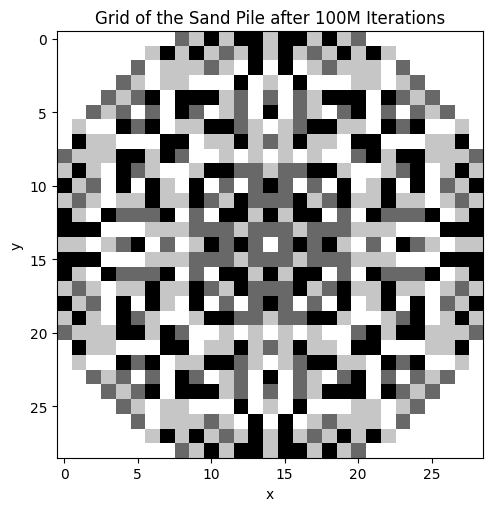

In [37]:
fig, ax = plt.subplots()
_, _ = model.visualise_grid(29, 29, fig=fig, ax=ax)
ax.set_title("Grid of the Sand Pile after 100M Iterations")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.show()
fig.savefig("out/grid.jpg")

### Statistics on BTW

In this subsection, we study the mean height of BTW models.


In [6]:
# Make a grid graph and create the model.
graph, boundary = sow.make_grid_graph(19, 19)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
mean_collector = sow.StatisticsCollector(sow.ContextTransformer.mean_height)
model.add_listener([mean_collector])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(15_000)
mean_height = mean_collector.value_history

The mean value is 1.6275
The sample variance is 0.0020


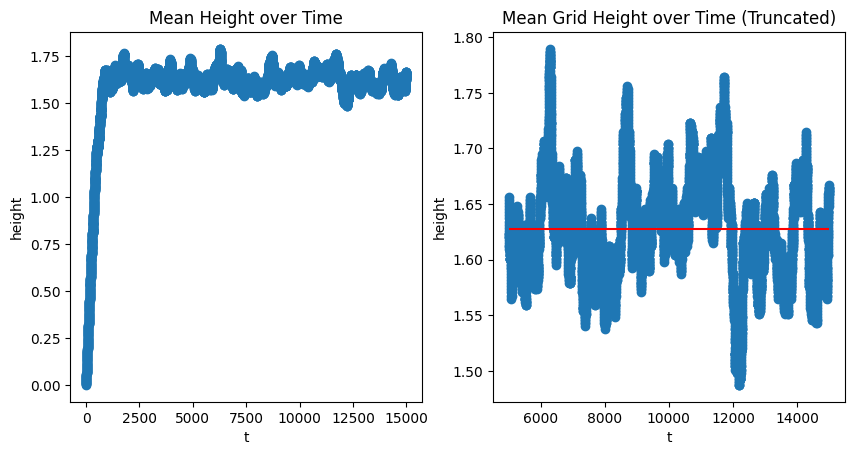

In [7]:
fig, ax = plt.subplots(ncols=2)

# Plots the result as a graph.
ax[0].scatter(np.arange(0, len(mean_height)), mean_height)
ax[0].set_title("Mean Height over Time")
ax[0].set_xlabel("t")
ax[0].set_ylabel("height")

# Let us focus on the flat tail.
ax[1].scatter(np.arange(0, len(mean_height))[5000:], mean_height[5000:])
ax[1].hlines(np.mean(mean_height[5000:]), 5000, len(mean_height), color="r")
ax[1].set_title("Mean Grid Height over Time (Truncated)")
ax[1].set_xlabel("t")
ax[1].set_ylabel("height")

# Display the figure
fig.set_figwidth(10)
fig.show()
fig.savefig("out/grid_mean_height.jpg")

# Prints the mean and variance of the truncated plot.
print(f"The mean value is {np.mean(mean_height[5000:]):.4f}")
print(f"The sample variance is {np.var(mean_height[5000:]):.4f}")

### Topple Statistics and Avalanche Properties

Here we study the toppling behaviour of grid BTW and investigate avalanche 
properties of the model.

In [8]:
# Make a grid graph and create the model.
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
topple_occurrence_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_occurrence)
loss_collector = sow.StatisticsCollector(
    sow.ContextTransformer.sand_loss)
drop_location_collector = sow.StatisticsCollector(
    sow.ContextTransformer.drop_location)
model.add_listener([
    topple_occurrence_collector, loss_collector, drop_location_collector
])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000_000)
avalanche_duration, avalanche_loss, avalanche_area = (sow.avalanche_statistics(
    topple_occurrence_collector.value_history, 
    loss_collector.value_history, 
    drop_location_collector.value_history))

#### Avalanche Sand Loss Distribution and Area Distribution

These are the number of sand lost per avalanche and the area of an avalanche, i.e., the number of distinct nodes it covers.

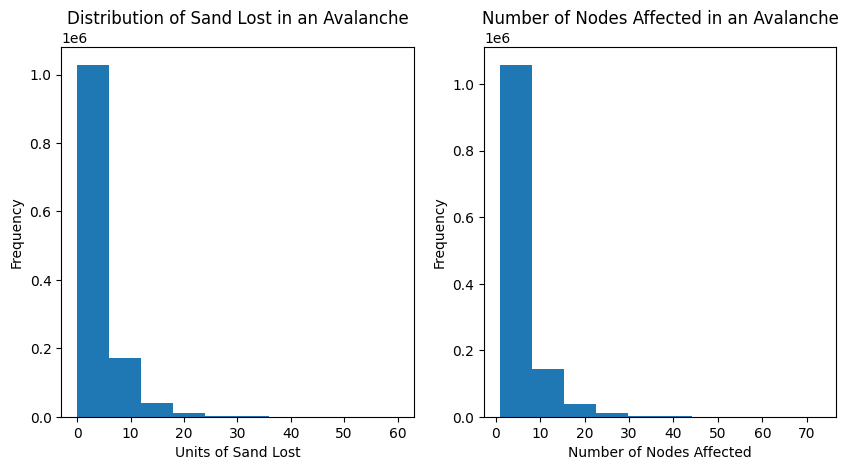

In [9]:
fig, ax = plt.subplots(ncols=2)

# Plots the avalanche sand loss.
ax[0].hist(avalanche_loss)
ax[0].set_title("Distribution of Sand Lost in an Avalanche")
ax[0].set_xlabel("Units of Sand Lost")
ax[0].set_ylabel("Frequency")

# Plots the area covered by an avalanche.
ax[1].hist(avalanche_area)
ax[1].set_title("Number of Nodes Affected in an Avalanche")
ax[1].set_xlabel("Number of Nodes Affected")
ax[1].set_ylabel("Frequency")

# Display and save the figure.
fig.set_figwidth(10)
fig.show()
fig.savefig("out/grid_avalanche.jpg")

#### Fitting the Distributions and Truncating the Tails

We first attempt to visualise the empirical distribution function and then try
to fit a linear curve on the candidate.
Observe that the tails are flat. We try again after truncating a small portion
of the tail and we have a much better fit.

LinAlgError: SVD did not converge

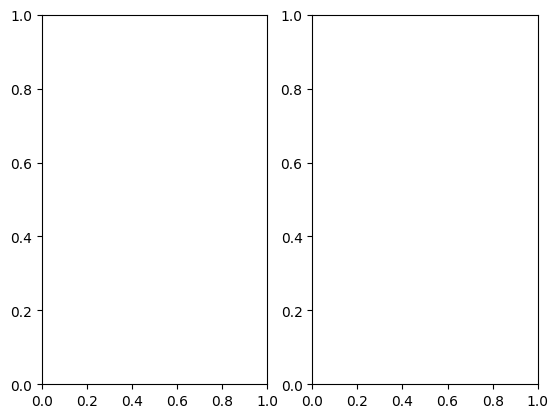

In [10]:
# Fitting the distribution. 
# For robustness, we fit the empirical distribution function instead.
fig, ax = plt.subplots(ncols=2)
edf_x, edf_y = sow.edf_transform(avalanche_loss)
_, _, _ = sow.fit_and_plot(np.log(edf_x), edf_y, fig=fig, ax=ax[0])

# Makes the plot look better.
ax[0].set_title("Avalanche Sand Loss Empirical Distribution")
ax[0].set_xlabel("log(edf_x)")
ax[0].set_ylabel("probabilities")

# Truncate the tail and fit again.
edf_x_fit = np.array(edf_x)[edf_y < 0.95]
edf_y_fit = edf_y[edf_y < 0.95]
_, _, _ = sow.fit_and_plot(np.log(edf_x_fit), edf_y_fit, fig=fig, ax=ax[1])

# Makes the plot look better.
ax[1].set_title("Avalanche Sand Loss Empirical Distribution (Truncated)")
ax[1].set_xlabel("log(edf_x)")
ax[1].set_ylabel("probabilities")

# Display the result.
fig.set_figwidth(10)
fig.show()
fig.savefig("out/grid_avalanche_loss.jpg")

In [ ]:
# Fitting the distribution. 
# For robustness, we fit the empirical distribution function instead.
fig, ax = plt.subplots(ncols=2)
edf_x, edf_y = sow.edf_transform(avalanche_area)
_, _, _ = sow.fit_and_plot(np.log(edf_x), edf_y, fig=fig, ax=ax[0])

# Makes the plot look better.
ax[0].set_title("Avalanche Area Empirical Distribution")
ax[0].set_xlabel("log(edf_x)")
ax[0].set_ylabel("probabilities")

# Truncate the tail and fit again.
edf_x_fit = np.array(edf_x)[edf_y < 0.95]
edf_y_fit = edf_y[edf_y < 0.95]
_, _, _ = sow.fit_and_plot(np.log(edf_x_fit), edf_y_fit, fig=fig, ax=ax[1])

# Makes the plot look better.
ax[1].set_title("Avalanche Area Empirical Distribution (Truncated)")
ax[1].set_xlabel("log(edf_x)")
ax[1].set_ylabel("probabilities")

# Display the result.
fig.set_figwidth(10)
fig.show()
fig.savefig("out/grid_avalanche_area.jpg")

#### Avalanche Duration

This section plots avalanche duration, i.e., number of topples per avalanche.

In [ ]:
plt.hist(avalanche_duration)
plt.show()

## The Tree

In the section we look at the tree model.

### What does it Look Like? Pattern at Scale

In [ ]:
# Make a graph and create a visualisation.
graph, boundary = sow.make_interesting_tree(3, 2)
model = sow.Model(graph=graph, boundary_vertices=boundary)
model.manager = sow.ConstantDropper(0)
model.simulate(63)
fig, ax = model.visualise_graph()

# Display and save the figure.
ax.set_title("The Tree of Interest (n=3, d=2)")
fig.show()
fig.savefig("out/tree.jpg")

### Mean Height

In [ ]:
# Make a graph and create the model.
graph, boundary = sow.make_interesting_tree(3, 4)
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
mean_collector = sow.StatisticsCollector(sow.ContextTransformer.mean_height)
model.add_listener([mean_collector])

# Simulate the model.
model.simulate(15_000)
mean_height = mean_collector.value_history

In [ ]:
fig, ax = plt.subplots(ncols=2)

# Plots the result as a graph.
ax[0].scatter(np.arange(0, len(mean_height)), mean_height)
ax[0].set_title("Mean Height over Time")
ax[0].set_xlabel("t")
ax[0].set_ylabel("height")

# Let us focus on the flat tail.
ax[1].scatter(np.arange(0, len(mean_height))[5000:], mean_height[5000:])
ax[1].hlines(np.mean(mean_height[5000:]), 5000, len(mean_height), color="r")
ax[1].set_title("Mean Height over Time (Truncated)")
ax[1].set_xlabel("t")
ax[1].set_ylabel("height")

# Display the figure
fig.set_figwidth(10)
fig.show()
fig.savefig("out/tree_mean_height.jpg")

# Prints the mean and variance of the truncated plot.
print(f"The mean value is {np.mean(mean_height[5000:]):.4f}")
print(f"The sample variance is {np.var(mean_height[5000:]):.4f}")

### Avalanche Loss

In [ ]:
# Make a grid graph and create the model.
model = sow.Model(graph=graph, boundary_vertices=boundary)

# Add the mean collector listener.
topple_occurrence_collector = sow.StatisticsCollector(
    sow.ContextTransformer.topple_occurrence)
loss_collector = sow.StatisticsCollector(
    sow.ContextTransformer.sand_loss)
drop_location_collector = sow.StatisticsCollector(
    sow.ContextTransformer.drop_location)
model.add_listener([
    topple_occurrence_collector, loss_collector, drop_location_collector
])

# No more listeners since they will slow it down. We are only interested in the 
# final image anyway, at this stage.
model.simulate(10_000_000)
avalanche_duration, avalanche_loss, avalanche_area = (sow.avalanche_statistics(
    topple_occurrence_collector.value_history, 
    loss_collector.value_history, 
    drop_location_collector.value_history))

In [ ]:
fig, ax = plt.subplots(ncols=2)

# Plots the avalanche sand loss.
ax[0].hist(avalanche_loss)
ax[0].set_title("Distribution of Sand Lost in an Avalanche")
ax[0].set_xlabel("Units of Sand Lost")
ax[0].set_ylabel("Frequency")

# Plots the area covered by an avalanche.
ax[1].hist(avalanche_area)
ax[1].set_title("Number of Nodes Affected in an Avalanche")
ax[1].set_xlabel("Number of Nodes Affected")
ax[1].set_ylabel("Frequency")

# Display and save the figure.
fig.set_figwidth(10)
fig.show()
fig.savefig("out/tree_avalanche.jpg")

In [ ]:
# Fitting the distribution. 
# For robustness, we fit the empirical distribution function instead.
fig, ax = plt.subplots(ncols=2)
edf_x, edf_y = sow.edf_transform(avalanche_duration)
result, _, _ = sow.fit_and_plot(edf_x, edf_y, fig=fig, ax=ax[0])

# Truncate the tail and fit again.
edf_x_fit = np.array(edf_x)[edf_y <= 0.95]
edf_y_fit = edf_y[edf_y <= 0.95]
_, _, _ = sow.fit_and_plot(edf_x_fit, np.log(1 - edf_y_fit), fig=fig, ax=ax[1])

# Makes the plot look better.
ax[0].set_title("Avalanche Sand Loss Empirical Distribution")
ax[0].set_xlabel("log(edf_x)")
ax[0].set_ylabel("probabilities")
ax[1].set_title("Avalanche Sand Loss Empirical Distribution (Truncated)")
ax[1].set_xlabel("log(edf_x)")
ax[1].set_ylabel("probabilities")
fig.set_figwidth(10)
fig.show()
fig.savefig("out/tree_avalanche_loss.jpg")

In [ ]:
# Fitting the distribution. 
# For robustness, we fit the empirical distribution function instead.
fig, ax = plt.subplots(ncols=2)
edf_x, edf_y = sow.edf_transform(avalanche_area)
_, _, _ = sow.fit_and_plot(edf_x, edf_y, fig=fig, ax=ax[0])

# Makes the plot look better.
ax[0].set_title("Avalanche Area Empirical Distribution")
ax[0].set_xlabel("log(edf_x)")
ax[0].set_ylabel("probabilities")

# Truncate the tail and fit again.
edf_x_fit = np.array(edf_x)[edf_y <= 0.95]
edf_y_fit = edf_y[edf_y <= 0.95]
_, _, _ = sow.fit_and_plot(edf_x_fit, np.log(1 - edf_y_fit), fig=fig, ax=ax[1])

# Makes the plot look better.
ax[1].set_title("Avalanche Area Empirical Distribution (Truncated)")
ax[1].set_xlabel("log(edf_x)")
ax[1].set_ylabel("probabilities")

# Display the figure.
fig.set_figwidth(10)
fig.show()
fig.savefig("out/tree_avalanche_area.jpg")